In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fastai.tabular.all import *
from multiprocessing import Pool
from sklearn.model_selection import KFold, GroupKFold
import lightgbm as lgb
from optiver_features import *
import pickle

In [9]:
df = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
time_ids = df.time_id.unique()
np.random.seed(42)
np.random.shuffle(time_ids)

splt = int(len(time_ids)*.7)
train_ids, test_ids = time_ids[:splt], time_ids[splt:]

len(train_ids), len(test_ids)

(2681, 1149)

In [11]:
len(df[df.time_id.isin(train_ids)]) / len(df)

0.6999944047075061

## Generate 5m dataset

In [12]:
book_feature_dict = {
    wap1: [],
    wap2: [],
    log_return1: [np.std],
    log_return2: [np.std],
  
    price_spread:[np.mean],
    total_volume:[np.mean],
}
trade_feature_dict = {
        log_return_price: [np.std],
        'seconds_in_bucket':[np.size],
        'size':[np.sum],
        'order_count':[np.sum],
}
time_id_features=[]
time_id_aggregations = []
stock_id_features = []
stock_id_aggregations = [time_id_aggregations]
time_windows = [(0,300), (0,100), (100,200), (200,300)]

In [15]:
def generate_0_to_5():


    ofg = OptiverFeatureGenerator(book_feature_dict, trade_feature_dict, time_windows, time_id_features,time_id_aggregations, stock_id_features, stock_id_aggregations)
    train_df5m = ofg.generate_train_df()
    ofg_targ =OptiverFeatureGenerator({wap1:[], log_return1:[realized_volatility]}, {'seconds_in_bucket':[np.size]}, [(300,600)], [],[],[],[])
    targ_df = ofg_targ.generate_train_df()
    train_df5m.target = targ_df.log_return1_realized_volatility_300_600
    train_df5m.target = train_df5m.target.replace(0, 1e-4)
    return train_df5m
    

In [16]:
%%time
train_df5m = generate_0_to_5()

CPU times: user 2.59 s, sys: 773 ms, total: 3.36 s
Wall time: 4min 41s


In [19]:

train_df5m.to_feather('train_5m.feather')

In [20]:
def rename_col(x):
    return x.replace('300', '600').replace('200', '500').replace('100', '400').replace('_0', '_300')
def rename_col_back(x):
    return x.replace('300', '0').replace('400', '100').replace('500', '200').replace('600', '300')

def generate_5_to_10():
    tw = [(x+300, y+300) for x,y in time_windows]
    time_id_feat = [rename_col(x) for x in time_id_features]
    stock_id_feat = [rename_col(x) for x in stock_id_features]
    ofg = OptiverFeatureGenerator(book_feature_dict, trade_feature_dict, tw, time_id_feat,time_id_aggregations, stock_id_feat, stock_id_aggregations)

    df = ofg.generate_train_df()
    df.columns = [rename_col_back(x) for x in df.columns]
    return df

In [21]:
train_df5_10m  = generate_5_to_10()

In [22]:
train_df5_10m.to_feather('train_5_10.feather')

In [67]:
cols_to_keep = ['log_return2_std_0_300',
 
 'stock_id','row_id', 'time_id', 'target',
 'log_return_price_std_0_300',
  'order_count_sum_0_300',
 'seconds_in_bucket_size_0_300',
 'size_sum_0_300',
 'log_return1_std_0_300',
 'log_return1_std_100_200',
 'log_return1_std_200_300',
 'price_spread_mean_0_300',

 'total_volume_mean_0_300']

In [70]:
train_df5m = train_df5m[cols_to_keep]
train_df5_10m = train_df5_10m[cols_to_keep]

## LGBM Baseline

In [71]:
def rmspe_np(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))
def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe_np(y_true, y_pred), False

def train_models(train):
    # Hyperparammeters (optimized)
    seed = 29
    params = {
        'learning_rate': 0.1,        
        'lambda_l1': 2,
        'lambda_l2': 7,
        'num_leaves': 800,
        'min_sum_hessian_in_leaf': 20,
        'feature_fraction': 0.8,
        'feature_fraction_bynode': 0.8,
        'bagging_fraction': 0.9,
        'bagging_freq': 42,
        'min_data_in_leaf': 700,
        'max_depth': 4,
        'seed': seed,
        'feature_fraction_seed': seed,
        'bagging_seed': seed,
        'drop_seed': seed,
        'data_random_seed': seed,
        'objective': 'rmse',
        'boosting': 'gbdt',
        'verbosity': -1,
        'n_jobs': -1,
    }   
    x = train
    # Split features and target
    for c in ['row_id', 'target', 'time_id']:
        if c in x.columns:
            x = x.drop(c, axis=1)
    
    y = train['target']
    # Transform stock id to a numeric value
    x['stock_id'] = x['stock_id'].astype(int)
    models =[]
    # Create out of folds array
    oof_predictions = np.zeros(x.shape[0])
    # Create a KFold object
    kfold = GroupKFold()
    # Iterate through each fold
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(x, groups = train.time_id)):
        print(f'Training fold {fold + 1}')
        x_train, x_val = x.iloc[trn_ind], x.iloc[val_ind]
        y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        # Root mean squared percentage error weights
        train_weights = 1 / np.square(y_train)
        val_weights = 1 / np.square(y_val)
        train_dataset = lgb.Dataset(x_train, y_train, weight = train_weights, categorical_feature = ['stock_id'])
        val_dataset = lgb.Dataset(x_val, y_val, weight = val_weights, categorical_feature = ['stock_id'])
        model = lgb.train(params = params, 
                          train_set = train_dataset, 
                          valid_sets = [train_dataset, val_dataset], 
                          num_boost_round = 3000, 
                          early_stopping_rounds = 25, 
                          verbose_eval = 100,
                          feval = feval_rmspe)
        models.append(model)
        # Add predictions to the out of folds array
        oof_predictions[val_ind] = model.predict(x_val)
        # Predict the test set
        #test_predictions += model.predict(x_test) / 10
        
    rmspe_score = rmspe_np(y, oof_predictions)
    print(f'Our out of folds RMSPE is {rmspe_score}')
    # Return test predictions
    return models

In [72]:
_=train_models(train_df5m)

Training fold 1
Training until validation scores don't improve for 25 rounds


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1996: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1727: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1460: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[100]	training's rmse: 0.000357779	training's RMSPE: 0.244754	valid_1's rmse: 0.000370922	valid_1's RMSPE: 0.254099
[200]	training's rmse: 0.000350515	training's RMSPE: 0.239785	valid_1's rmse: 0.000367952	valid_1's RMSPE: 0.252064
[300]	training's rmse: 0.000346728	training's RMSPE: 0.237194	valid_1's rmse: 0.000366881	valid_1's RMSPE: 0.251331
[400]	training's rmse: 0.000344141	training's RMSPE: 0.235424	valid_1's rmse: 0.000366172	valid_1's RMSPE: 0.250845
[500]	training's rmse: 0.000342541	training's RMSPE: 0.23433	valid_1's rmse: 0.000365864	valid_1's RMSPE: 0.250634
Early stopping, best iteration is:
[574]	training's rmse: 0.000340901	training's RMSPE: 0.233208	valid_1's rmse: 0.000365659	valid_1's RMSPE: 0.250493
Training fold 2
Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000358507	training's RMSPE: 0.244747	valid_1's rmse: 0.000372946	valid_1's RMSPE: 0.257576
[200]	training's rmse: 0.000351373	training's RMSPE: 0.239876	valid_1's rmse:

## Learning embeddings

In [97]:
cont_nn,cat_nn = cont_cat_split(train_df5m, max_card=9000, dep_var='target')
cat_nn = ['time_id', 'stock_id']


procs_nn = [Categorify, FillMissing,Normalize]

splits = RandomSplitter(valid_pct=0.1,seed=43)(train_df5m)

dls = TabularPandas(train_df5m, procs_nn, cat_nn, cont_nn,
                      splits=splits, 
                       
                      y_names='target').dataloaders(1024)

def rmse(preds, targs):
    x = (targs-preds)
    return (x**2).mean().sqrt()

def rmspe(preds, targs):
    x = (targs-preds)/targs
    return (x**2).mean().sqrt()

config={'lin_first':True, 'ps':[.5,.2,0], 'embed_p':0.5, }
learn = tabular_learner(dls, y_range=(0,.1), layers=[200,100,40], emb_szs={'stock_id':3, 'time_id':6}, 
                        n_out=1, 
                        loss_func = rmspe, 
                        
                        metrics=AccumMetric(rmspe), config=config)

In [98]:
learn.fit_one_cycle(20, 5e-3)

epoch,train_loss,valid_loss,rmspe,time
0,8.325928,6.220598,6.224858,00:02
1,0.879058,0.496816,0.503664,00:02
2,0.321770,0.269856,0.270382,00:02
3,0.352682,0.251660,0.252113,00:02
4,0.282145,0.245652,0.246303,00:02
5,0.284238,0.244403,0.244851,00:02
6,0.265647,0.237470,0.238125,00:02
7,0.269429,0.238203,0.238674,00:02
8,0.265408,0.237279,0.237939,00:02
9,0.256498,0.236807,0.237445,00:02


In [99]:
categorify = dls.procs[2]
time_embs = learn.model.embeds[0].weight.data.cpu()
stock_embs = learn.model.embeds[1].weight.data.cpu()

In [100]:
def append_embs(data_df, categorify, time_embs, stock_embs):
    time_id_embs = dict()
    for idx, time_id in enumerate(categorify.classes['time_id']):
        time_id_embs[time_id] = time_embs[idx].tolist()

    stock_id_embs = dict()
    for idx, stock_id in enumerate(categorify.classes['stock_id']):
        stock_id_embs[stock_id] = stock_embs[idx].tolist()

    all_embs = []
    for _, row in (data_df[['stock_id', 'time_id']].iterrows()):
        emb1 = stock_id_embs[row.stock_id]
        emb2 = time_id_embs[row.time_id]
        all_embs.append(emb1+emb2)
    columns = [f'stock_emb{i}' for i in range(stock_embs.shape[1])] +[f'time_emb{i}' for i in range(time_embs.shape[1])]
    embs_df = pd.DataFrame(all_embs, columns=columns)

    return pd.concat([data_df, embs_df], axis=1)

In [101]:
test_df = train_df5_10m
test_dl = dls.test_dl(test_df)
preds, _ = learn.get_preds(dl=test_dl)
preds5_10 = preds.view(-1).numpy()

## Train 5m LGBM with embeddings


In [78]:
train_5_with_embs = append_embs(train_df5m, categorify, time_embs, stock_embs)



In [79]:
_=train_models(train_5_with_embs)

Training fold 1


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1996: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1727: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1460: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000323135	training's RMSPE: 0.221054	valid_1's rmse: 0.000332743	valid_1's RMSPE: 0.227944
[200]	training's rmse: 0.000315026	training's RMSPE: 0.215507	valid_1's rmse: 0.000328246	valid_1's RMSPE: 0.224864
[300]	training's rmse: 0.000311295	training's RMSPE: 0.212955	valid_1's rmse: 0.000326663	valid_1's RMSPE: 0.22378
[400]	training's rmse: 0.000308504	training's RMSPE: 0.211045	valid_1's rmse: 0.000325889	valid_1's RMSPE: 0.223249
[500]	training's rmse: 0.00030636	training's RMSPE: 0.209579	valid_1's rmse: 0.000325633	valid_1's RMSPE: 0.223074
Early stopping, best iteration is:
[482]	training's rmse: 0.000306678	training's RMSPE: 0.209797	valid_1's rmse: 0.000325546	valid_1's RMSPE: 0.223015
Training fold 2
Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000322796	training's RMSPE: 0.220368	valid_1's rmse: 0.000337277	valid_1's RMSPE: 0.232941
[200]	training's 

## Baseline LGBM 10m

In [191]:
# time_windows = [(0,600), (200, 600), (400,600)]

# agg_cols = ['log_return_price_std', 'log_return1_std', 'log_return2_std']

# time_id_features = [f'{col}_{x}_{y}' for x,y in time_windows for col in agg_cols] 
# time_id_aggregations = ['mean', 'std', 'min' ]
# stock_id_features = time_id_features
# stock_id_aggregations = time_id_aggregations

# ofg = OptiverFeatureGenerator(book_feature_dict, trade_feature_dict, time_windows, time_id_features,time_id_aggregations, stock_id_features, stock_id_aggregations)
# df = ofg.generate_train_df()



In [192]:
# cols_to_keep = ['log_return2_std_0_600',
 
#  'stock_id','row_id', 'time_id', 'target',
#  'log_return_price_std_0_600',
#   'order_count_sum_0_600',
#  'seconds_in_bucket_size_0_600',
#  'size_sum_0_600',
#  'log_return1_std_0_600_min_time',
#  'log_return1_std_0_600_mean_time',
#  'log_return1_std_0_600_min_stock',
#  'log_return1_std_0_600_mean_stock',
#  'log_return1_std_0_600',
#  'log_return1_std_200_600',
#  'log_return1_std_400_600',
#  'price_spread_mean_0_600',
#  'log_return_price_std_0_600_mean_time',
#  'log_return_price_std_200_600_mean_time',
#  'log_return_price_std_400_600_mean_time',
#  'log_return_price_std_0_600_min_time',
#  'log_return_price_std_200_600_min_time',
#  'log_return_price_std_400_600_min_time',
#  'total_volume_mean_0_600']

# df = df[cols_to_keep]

# df.to_feather('train_24cols.feather')

In [80]:
df = pd.read_feather('train_24cols.feather')

In [81]:
train_df10m = df[df.time_id.isin(train_ids)].reset_index()
test_df10m = df[df.time_id.isin(test_ids)].reset_index()
len(train_df10m), len(test_df10m)

(300250, 128682)

In [82]:
models=train_models(train_df10m)

Training fold 1
Training until validation scores don't improve for 25 rounds


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1996: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1727: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1460: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[100]	training's rmse: 0.000467282	training's RMSPE: 0.218349	valid_1's rmse: 0.00048106	valid_1's RMSPE: 0.220792
[200]	training's rmse: 0.000449861	training's RMSPE: 0.210209	valid_1's rmse: 0.000475599	valid_1's RMSPE: 0.218285
[300]	training's rmse: 0.000441072	training's RMSPE: 0.206102	valid_1's rmse: 0.000473911	valid_1's RMSPE: 0.21751
Early stopping, best iteration is:
[363]	training's rmse: 0.00043607	training's RMSPE: 0.203765	valid_1's rmse: 0.000473137	valid_1's RMSPE: 0.217155
Training fold 2
Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000468436	training's RMSPE: 0.217662	valid_1's rmse: 0.000477137	valid_1's RMSPE: 0.224011
[200]	training's rmse: 0.000451397	training's RMSPE: 0.209744	valid_1's rmse: 0.000474375	valid_1's RMSPE: 0.222714
Early stopping, best iteration is:
[235]	training's rmse: 0.000447641	training's RMSPE: 0.207999	valid_1's rmse: 0.000473793	valid_1's RMSPE: 0.222441
Training fold 3
Training until validation sc

In [83]:
test_pred = np.zeros(len(test_df10m))
for model in models:
    pred = model.predict(test_df10m.drop(['row_id', 'time_id', 'target'], axis=1)) 
    test_pred += pred /5

baseline_score = rmspe_np(test_df10m.target, test_pred)
baseline_score

0.22725182948338465

## LGBM 10m with trained embeddings

In [102]:
df_with_embs = append_embs(df, categorify, time_embs, stock_embs)

In [103]:
df_with_embs['5m_pred']= preds5_10

In [104]:
train_10m_with_embs = df_with_embs[df_with_embs.time_id.isin(train_ids)].reset_index().drop('index',axis=1)
test_10m_with_embs = df_with_embs[df_with_embs.time_id.isin(test_ids)].reset_index().drop('index',axis=1)

In [105]:
models=train_models(train_10m_with_embs)

Training fold 1


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1996: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1727: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1460: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.00045867	training's RMSPE: 0.214325	valid_1's rmse: 0.000480631	valid_1's RMSPE: 0.220595
[200]	training's rmse: 0.000441963	training's RMSPE: 0.206518	valid_1's rmse: 0.000477115	valid_1's RMSPE: 0.218981
Early stopping, best iteration is:
[253]	training's rmse: 0.000436032	training's RMSPE: 0.203747	valid_1's rmse: 0.000476711	valid_1's RMSPE: 0.218796
Training fold 2
Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000460405	training's RMSPE: 0.21393	valid_1's rmse: 0.000471924	valid_1's RMSPE: 0.221564
Early stopping, best iteration is:
[170]	training's rmse: 0.000447939	training's RMSPE: 0.208138	valid_1's rmse: 0.000469588	valid_1's RMSPE: 0.220467
Training fold 3
Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.00045947	training's RMSPE: 0.213701	valid_1's rmse: 0.000482371	valid_1's RMSPE: 0.225611
[200]	training's rmse:

In [106]:
test_pred = np.zeros(len(test_10m_with_embs))
for model in models:
    pred = model.predict(test_10m_with_embs.drop(['row_id', 'time_id', 'target'], axis=1)) 
    test_pred += pred /5

embeds5mpred_score = rmspe_np(test_10m_with_embs.target, test_pred)
embeds5mpred_score

0.22158290739883277

In [107]:
(baseline_score-embeds5mpred_score)/ baseline_score

0.024945550922248417

In [108]:
# for m in models[:2]:
#     lgb.plot_importance(m, max_num_features=20)

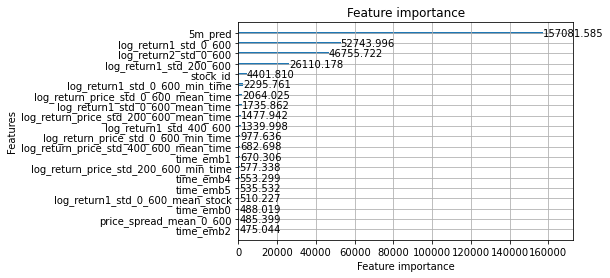

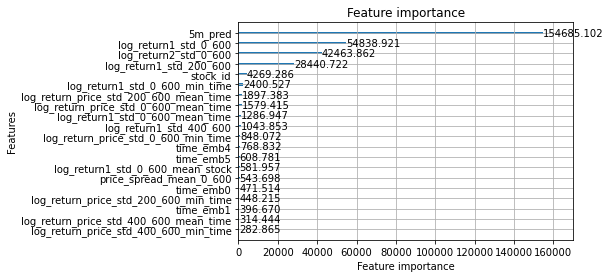

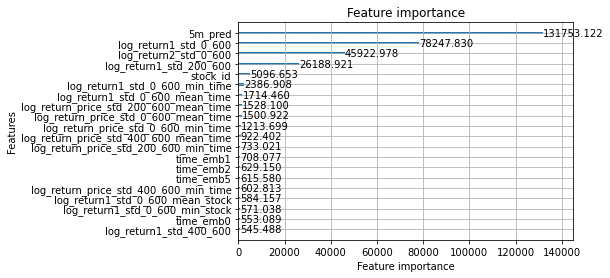

In [109]:
for m in models[:3]:
    lgb.plot_importance(m, max_num_features=20, importance_type='gain')

## Train NN

In [118]:
def rmspe(preds, targs):
    x = (targs-preds)/targs
    return (x**2).mean().sqrt()

In [171]:
splits = GroupKFold().split(train_10m_with_embs, groups = train_10m_with_embs.time_id)


def train_nn(train_df, test_df, split):
    cont_nn,cat_nn = cont_cat_split(train_df, max_card=9000, dep_var='target')
    cat_nn = []


    procs_nn = [Categorify, FillMissing,Normalize]
    dls = TabularPandas(train_df, procs_nn, cat_nn, cont_nn,
                          splits=split, y_names='target').dataloaders(1024)

 

    config={'lin_first':True, 'ps':[0.5,0,0], }
    learn = tabular_learner(dls, y_range=(0,.1), layers=[300,100,10], 
                            n_out=1, 
                            loss_func = rmspe, 
                            metrics=AccumMetric(rmspe), config=config)
    learn.fit_one_cycle(50, 5e-3, wd=.1)
    
    test_dl = dls.test_dl(test_df)
    preds, _ = learn.get_preds(dl=test_dl)
    score =rmspe_np(test_10m_with_embs.target, preds.view(-1).numpy())
    print(score)
    return preds

In [172]:
preds=[]
for trn_idx, val_idx in splits:
    p = train_nn(train_10m_with_embs, test_10m_with_embs, [list(trn_idx), list(val_idx)])
    preds.append(p)

epoch,train_loss,valid_loss,rmspe,time
0,12.096747,10.575679,10.593002,00:01
1,7.698064,6.065282,6.101762,00:01
2,3.425298,2.076310,2.111135,00:01
3,1.095390,0.796908,0.819899,00:01
4,0.539969,0.684458,0.689391,00:01
5,0.562535,0.271953,0.335323,00:01
6,0.353310,0.242173,0.245116,00:01
7,0.266519,0.261642,0.263729,00:01
8,0.375216,0.241855,0.244739,00:01
9,0.354436,0.247018,0.249121,00:01


0.21874312067929355


epoch,train_loss,valid_loss,rmspe,time
0,9.534526,8.850706,8.868313,00:01
1,6.362843,5.133828,5.164477,00:01
2,2.781911,1.752575,1.777459,00:01
3,0.953060,0.472724,0.513058,00:01
4,0.481445,0.384752,0.740647,00:01
5,0.283236,0.251039,0.264697,00:01
6,0.273919,0.239624,0.241638,00:01
7,0.277367,0.237082,0.239715,00:01
8,0.305947,0.224551,0.226318,00:01
9,0.402116,0.253842,0.257579,00:01


0.21885587456348346


epoch,train_loss,valid_loss,rmspe,time
0,10.781429,9.722219,9.745042,00:01
1,6.877950,5.202859,5.239921,00:01
2,3.065164,1.794070,1.824885,00:01
3,1.200922,0.684912,0.737261,00:01
4,0.589124,0.565148,0.574750,00:01
5,0.464481,0.575819,1.707331,00:01
6,0.283517,0.241579,0.246692,00:01
7,0.253323,0.235341,0.237933,00:01
8,0.246494,0.235012,0.237540,00:01
9,0.241887,0.245480,0.248016,00:01


0.22050307014148335


epoch,train_loss,valid_loss,rmspe,time
0,9.020046,8.238890,8.262155,00:01
1,6.218567,5.178564,5.195607,00:01
2,2.912152,2.036504,2.056745,00:01
3,0.654645,0.374688,0.442333,00:01
4,0.444193,0.472312,1.232040,00:01
5,0.286712,0.246279,0.248128,00:01
6,0.249882,0.233705,0.235040,00:01
7,0.293049,0.233408,0.235057,00:01
8,0.249616,0.235669,0.236865,00:01
9,0.240702,0.236756,0.238343,00:01


0.21961120016159139


epoch,train_loss,valid_loss,rmspe,time
0,11.893058,11.173452,11.184654,00:01
1,8.205441,7.011562,7.036065,00:01
2,3.948891,2.710476,2.739542,00:01
3,1.234502,0.509835,0.522458,00:01
4,0.457820,0.284170,0.290254,00:01
5,0.272891,0.236658,0.238672,00:01
6,0.250031,0.229280,0.230559,00:01
7,0.244011,0.227957,0.229184,00:01
8,0.568234,0.285342,0.287057,00:01
9,0.256447,0.230632,0.231831,00:01


0.21941527113428277


In [173]:
score = rmspe_np(test_10m_with_embs.target,torch.cat(preds, dim=1).mean(dim=1).numpy())

score, (baseline_score-score)/ baseline_score

(0.2183781793544065, 0.039047651009678386)

In [174]:
score = rmspe_np(test_10m_with_embs.target,torch.cat(preds, dim=1).median(dim=1)[0].numpy())

score, (baseline_score-score)/ baseline_score

(0.21892971496993563, 0.0366206711398884)